# Long-short strategy

Trades with multiple assets

In [1]:
import epymetheus

import pandas as pd
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
try:
    import seaborn
    seaborn.set_style('ticks')
except ImportError:
    pass
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from epymetheus import Universe, Trade, TradeStrategy

/usr/local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from epymetheus.datasets import fetch_usstocks

universe = fetch_usstocks(n_assets=10)
universe.prices

,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
2000-01-01,3.187337,37.453701,76.125000,56100,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-02,3.187337,37.453701,76.125000,56100,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-03,3.470226,37.393559,89.375000,54800,26.407299,26.965630,46.195686,11.966080,28.580635,21.549223
2000-01-04,3.177650,36.130390,81.937500,52000,25.901106,25.978415,44.467136,11.255836,28.030689,21.136469
2000-01-05,3.224152,36.511333,69.750000,53200,25.741232,26.252653,43.559650,11.379356,27.497412,22.288738
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-28,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-29,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-30,290.829773,157.160736,1846.890015,338750,136.329041,144.379349,118.874016,34.927143,123.734962,68.496635


In [3]:
class SimpleLongShort(TradeStrategy):
    """Simple long-short strategy."""
    def __init__(self, percentile, bet):
        self.percentile = percentile
        self.bet = bet
    
    def logic(self, universe):
        watch_period = DateOffset(months=1)
        trade_period = DateOffset(months=1)
        n_trade = int(universe.n_assets * self.percentile)

        def trade_open_dates(universe, watch_period, trade_period):
            """Yield begin_date of trades."""
            open_date = universe.bars[0] + watch_period
            while open_date + trade_period <= universe.bars[-1]:
                yield open_date
                open_date += trade_period

        def tot_returns(open_date):
            """Return 1 month return of assets as Series."""
            b = open_date - DateOffset(days=1)
            e = open_date - DateOffset(months=1)
            return universe.prices.loc[e, :] / universe.prices.loc[b, :]

        for open_date in trade_open_dates(universe, watch_period, trade_period):
            shut_date = open_date + trade_period
            r = tot_returns(open_date)
            assets_sorted = sorted(universe.assets, key=lambda asset: r[asset])

            for asset_l, asset_s in zip(assets_sorted[-n_trade:], assets_sorted[:n_trade]):
                lot_l = +self.bet / universe.prices.at[open_date, asset_l]
                lot_s = -self.bet / universe.prices.at[open_date, asset_s]
                yield Trade(
                    asset=[asset_l, asset_s], 
                    lot=[lot_l, lot_s],
                    open_bar=open_date,
                    shut_bar=shut_date,
                )

In [4]:
strategy = SimpleLongShort(percentile=0.2, bet=10000)

In [5]:
strategy.run(universe)

Running ... 
Generating 476 trades ({trade.open_bar}) ... Done. (Runtime : 0.44 sec)
Executing 476 trades ... Done. (Runtime : 0.45 sec)
Done. (Runtime : 0.92 sec)


In [6]:
history = strategy.history.to_dataframe()
# transaction = pd.DataFrame(strategy.transaction).set_index('bars')
wealth = strategy.wealth.to_dataframe()

In [7]:
history.head()

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,MSFT,302.822791,2000-02-01,2000-03-01,2000-03-01,None,None,-1177.900766
1,0,JPM,-326.730603,2000-02-01,2000-03-01,2000-03-01,None,None,208.954705
2,1,WMT,246.439657,2000-02-01,2000-03-01,2000-03-01,None,None,-1650.692768
3,1,XOM,-436.859122,2000-02-01,2000-03-01,2000-03-01,None,None,753.418836
4,2,BRK-A,0.223714,2000-03-01,2000-04-01,2000-04-01,None,None,2796.420582


In [8]:
# transaction.head()

In [9]:
wealth.tail()

,wealth
bars,
2019-12-27,7833.952821
2019-12-28,7833.952821
2019-12-29,7833.952821
2019-12-30,7833.952821
2019-12-31,7833.952821


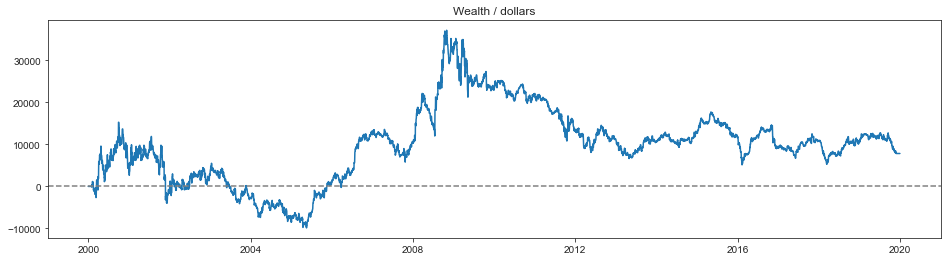

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(wealth)
plt.axhline(0, color='gray', ls='--')
plt.title('Wealth / dollars')
plt.show()

In [11]:
# net_exposure = (transaction.cumsum() * universe.prices).sum(axis=1)
# abs_exposure = (transaction.cumsum().applymap(abs) * universe.prices).sum(axis=1)

# plt.figure(figsize=(16, 8))

# plt.subplot(2, 1, 1)
# plt.plot(net_exposure)
# plt.axhline(0, color='gray', ls='--')
# plt.title('Net exposure / dollars')

# plt.subplot(2, 1, 2)
# plt.plot(abs_exposure)
# plt.axhline(0, color='gray', ls='--')
# plt.title('Abs exposure / dollars')

# plt.show()

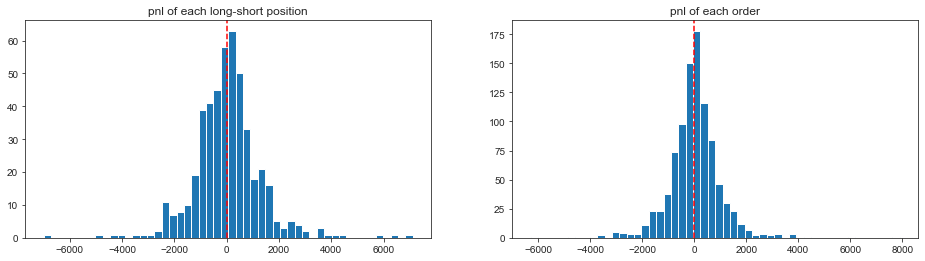

In [12]:
gains = history.pnl
gains_agg = history.loc[:, ['trade_id', 'pnl']].groupby('trade_id').agg('sum')

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.hist(gains_agg.values, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('pnl of each long-short position')

plt.subplot(1, 2, 2)
plt.hist(gains, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('pnl of each order')

plt.show()